## pytorch lstm

- https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>
<div style="text-align: right"> Initial upload: 2023.7. 11</div>
<div style="text-align: right"> Last update: 2023.7.11</div>

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline
# print(plt.stype.available)

# Options for pandas
pd.options.display.max_columns = 30

### 1. 입출력 shape 확인하기

In [2]:
import torch
import torch.nn as nn

In [3]:
batch_size = 16
timesteps = 5
input_size = 10
output_size = 20
num_layers = 1

lstm = nn.LSTM(
    input_size = input_size, # 10
    hidden_size = output_size, # 20
    num_layers = num_layers, # 1
    batch_first = True   
)

In [4]:
input = torch.randn(batch_size, timesteps, input_size)
h0 = torch.randn(num_layers, batch_size, output_size)
c0 = torch.randn(num_layers, batch_size, output_size)

In [5]:
output, (hn, cn) = lstm(input, (h0, c0))

In [6]:
assert (batch_size, timesteps, output_size) == output.shape
assert (num_layers, batch_size, output_size) == hn.shape
assert (num_layers, batch_size, output_size) == cn.shape

In [7]:
print(output.shape)
print(hn.shape)
print(cn.shape)

torch.Size([16, 5, 20])
torch.Size([1, 16, 20])
torch.Size([1, 16, 20])


### 2. forecasting model 구현하기

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler, MinMaxScaler

#### raw 데이터 읽기
- 비트코인 데이터

In [9]:
url="https://raw.githubusercontent.com/sguys99/datasets/master/BTC-USD.csv"
df = pd.read_csv(url, index_col = "Date", parse_dates = True)
df.drop(columns=['Adj Close'], inplace=True)
print(df.shape)

(3114, 5)


In [10]:
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2015-01-01,320.434998,320.434998,314.002991,314.248993,8036550
2015-01-02,314.079010,315.838989,313.565002,315.032013,7860650
2015-01-03,314.846008,315.149994,281.082001,281.082001,33054400
2015-01-04,281.145996,287.230011,257.612000,264.195007,55629100
2015-01-05,265.084015,278.341003,265.084015,274.473999,43962800


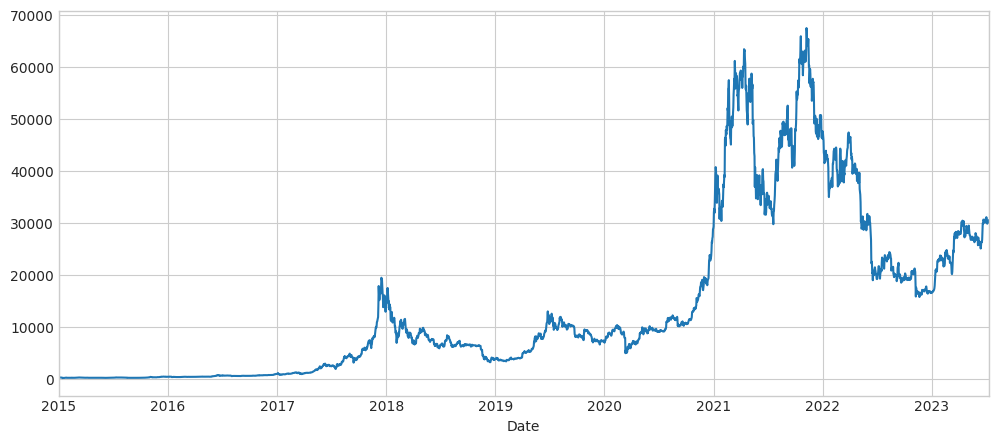

In [11]:
fig, ax = plt.subplots(figsize = (12, 5))
df.Close.plot(ax = ax)
plt.show()

#### 데이터셋 만들기

In [12]:
X, y = df.drop('Close', axis = 1), df.Close.values
X.shape, y.shape

((3114, 4), (3114,))

데이터 시퀀스 정의

In [13]:
def generate_sequences(
    df: pd.DataFrame,
    train_window: int,
    forecast_window: int,
    target_columns,
    drop_targets = False,
    ):
    '''
    df: Pandas DataFrame of the univariate time-series
    train_window: Integer defining how many steps to look back
    forecst_indow: Integer defining how many steps to predict
    target_colums
    drop_targets: drop target for training model 

    returns: dictionary of sequences and targets for all sequences
    '''
    if drop_targets:
            feature_df = df.drop(target_columns, axis=1)
    else:
        feature_df = df.copy()
    
    data = dict()
    L = len(df)
    for i in range(L-train_window):
        # train_window 사이즈 만큼 피처 시퀀스로 설정 
        sequence = feature_df[i:i+train_window].values
        # 현시점 이후부터 forecast_window 사이즈 만큼 타겟(예측) 범위로 지정
        target = df[i+train_window: i+train_window+forecast_window][target_columns].values
        data[i] = {'sequence': sequence, 'target': target}
        
    return data

In [14]:
# test
test = generate_sequences(df, 3, 2, 'Close')

In [15]:
test[0]['target']

array([264.195007, 274.473999])

In [16]:
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2015-01-01,320.434998,320.434998,314.002991,314.248993,8036550
2015-01-02,314.079010,315.838989,313.565002,315.032013,7860650
2015-01-03,314.846008,315.149994,281.082001,281.082001,33054400
2015-01-04,281.145996,287.230011,257.612000,264.195007,55629100
2015-01-05,265.084015,278.341003,265.084015,274.473999,43962800


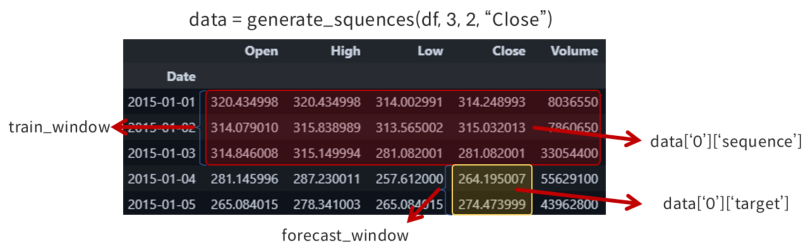

파이토치 Dataset 정의

In [17]:
class SequenceDataset(Dataset):

  def __init__(self, 
               data: pd.DataFrame
               ):
    self.data = data

  def __getitem__(self, idx):
    sample = self.data[idx]
    return torch.Tensor(sample['sequence']), torch.Tensor(sample['target'])
  
  def __len__(self):
    return len(self.data)

데이터 스케일링
- 입력 : standard scaler
- 타겟 : minmax scaler

In [18]:
feature_scalers = {}
target_scalers = {}
X = df.drop("Close", axis = 1)
y = df[["Close"]]

for feat in X.columns:
    feature_scalers[feat] = StandardScaler().fit(X[feat].values.reshape(-1, 1))
    
target_scalers["Close"] = MinMaxScaler().fit(y["Close"].values.reshape(-1, 1))

In [19]:
X_norm = X.copy()
y_norm = y.copy()

for i, key in enumerate(feature_scalers.keys()):
  feature_norm = feature_scalers[key].transform(X_norm.iloc[:, i].values.reshape(-1, 1))
  X_norm.iloc[:, i] = feature_norm
  
target_norm = target_scalers["Close"].transform(y_norm.loc[:, "Close"].values.reshape(-1, 1))
y_norm.loc[:,"Close"] = target_norm

In [20]:
X_norm.describe()

,Open,High,Low,Volume
count,3114.000000,3.114000e+03,3.114000e+03,3.114000e+03
mean,0.000000,7.301659e-17,7.301659e-17,7.301659e-17
std,1.000161,1.000161e+00,1.000161e+00,1.000161e+00
min,-0.863588,-8.612205e-01,-8.653139e-01,-8.741231e-01
25%,-0.810107,-8.101821e-01,-8.113344e-01,-8.629879e-01
50%,-0.372793,-3.744573e-01,-3.738570e-01,-2.505511e-01
75%,0.416664,4.201643e-01,4.255917e-01,5.643489e-01
max,3.322951,3.296025e+00,3.370145e+00,1.703687e+01


In [21]:
y_norm.describe()

,Close
count,3114.000000
mean,0.206334
std,0.238807
min,0.000000
25%,0.012764
50%,0.117180
75%,0.306143
max,1.000000


In [22]:
df_norm = pd.concat([X_norm, y_norm], axis = 1)

데이터셋 만들기
- `generate_sequences` -> `SequenceDataSet` -> `DataLoader`

In [23]:
BATCH_SIZE = 16
train_window = 10
forecast_window = 1

split = 0.8

In [24]:
sequences = generate_sequences(
    df = df_norm,
    train_window=train_window,
    forecast_window=forecast_window,
    target_columns="Close"
)

In [25]:
sequences[0]["target"]

array([0.00129928])

In [26]:
dataset = SequenceDataset(sequences)

In [27]:
train_len = int(len(dataset)*split)
lens = [train_len, len(dataset)-train_len]
lens

[2483, 621]

In [28]:
train_ds, test_ds = random_split(dataset, lens)

In [29]:
trainloader = DataLoader(
    train_ds, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    drop_last=True
    )

testloader = DataLoader(
    test_ds, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    drop_last=True
    )

In [30]:
x, y = next(iter(trainloader))
x.shape, y.shape

(torch.Size([16, 10, 5]), torch.Size([16, 1]))

#### 모델 정의

In [31]:
class LSTMForecaster(nn.Module):
    
    def __init__(self,
                 input_size,
                 hidden_size,
                 n_outputs,
                 sequence_len, # length of lookback
                 n_lstm_layers = 1,
                 n_dnn_layers = 100,
                 device = 'cpu',
                 use_cuda = False,
                 dropout = 0.2
                 ):
        '''
        input_size: 입력 피처 수 (1이면 단변량 예측)
        hidden_size: LSTM hidden state size
        n_outputs: 출력(예측) 크기
        n_dnn_layers: LSTM 후단의 DNN layer size
        sequence_len: look back size
        dropout: 0 ~ 1
        '''
        super().__init__()
        
        self.input_size = input_size
        self.sequence_len = sequence_len
        self.n_lstm_layers = n_lstm_layers
        self.n_hidden = hidden_size
        self.n_outputs = n_outputs
        self.device = device
        self.use_cuda = use_cuda
        
        self.lstm = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.n_hidden,
            num_layers = self.n_lstm_layers,
            batch_first = True
        )
        self.fc1 = nn.Linear(
            in_features=self.n_hidden * self.sequence_len,
            out_features= self.n_hidden
            )
        self.dropout = nn.Dropout(p = dropout)
        
        # Create fully connected layers (n_hidden x n_deep_layers)
        dnn_layers = []
        for i in range(n_dnn_layers):
            # Last layer (n_hidden x n_outputs)
            if i == n_dnn_layers - 1:
                dnn_layers.append(nn.ReLU())
                dnn_layers.append(nn.Linear(self.n_hidden, self.n_outputs))
            # All other layers (n_hidden x n_hidden) with dropout option
            else:
                dnn_layers.append(nn.ReLU())
                dnn_layers.append(nn.Linear(self.n_hidden, self.n_hidden))
                if dropout:
                    dnn_layers.append(nn.Dropout(p=dropout))
        # compile DNN layers
        self.dnn = nn.Sequential(*dnn_layers)
        
    def forward(self, x):
        # Initialize hidden state
        hidden_state = torch.zeros(self.n_lstm_layers, x.shape[0], self.n_hidden)
        cell_state = torch.zeros(self.n_lstm_layers, x.shape[0], self.n_hidden)

        # move hidden state to device
        if self.use_cuda:
            hidden_state = hidden_state.to(self.device)
            cell_state = cell_state.to(self.device)
        
        self.lstm_hidden = (hidden_state, cell_state)

        # Forward Pass
        x, h = self.lstm(x, self.lstm_hidden) # LSTM
        x = self.dropout(x.contiguous().view(x.shape[0], -1)) # Flatten lstm out 
        x = self.fc1(x) # DNN1
        return self.dnn(x) # DNN2

#### 모델 생성

In [32]:
lr = 4e-4
n_epochs = 20
device = "cpu"

input_size = 5
hidden_size = 50
n_dnn_layers = 5

model = LSTMForecaster(
    input_size=input_size,
    hidden_size=hidden_size,
    n_outputs=forecast_window,
    sequence_len=train_window,
    n_lstm_layers=1,
    n_dnn_layers=n_dnn_layers
    ).to(device)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

#### 모델 학습

In [33]:
t_losses, v_losses = [], []
for epoch in range(n_epochs):
    train_loss, valid_loss = 0.0, 0.0

    # train step
    model.train()
    for x, y in trainloader:
        optimizer.zero_grad()
        x = x.to(device)
        y  = y.squeeze().to(device)
        # Forward Pass
        preds = model(x).squeeze()
    
        loss = criterion(preds, y)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    epoch_loss = train_loss / len(trainloader)
    t_losses.append(epoch_loss)
  
    # validation step
    model.eval()
    for x, y in testloader:
        with torch.no_grad():
            x, y = x.to(device), y.squeeze().to(device)
            preds = model(x).squeeze()
            error = criterion(preds, y)
        valid_loss += error.item()
    valid_loss = valid_loss / len(testloader)
    v_losses.append(valid_loss)
      
    print(f'{epoch} - train: {epoch_loss}, valid: {valid_loss}')

0 - train: 0.02295588948538587, valid: 0.0009287283648614233
1 - train: 0.005748698357943325, valid: 0.0013199490031662495
2 - train: 0.005049047390029075, valid: 0.0024659995663234057
3 - train: 0.0044502452432718725, valid: 0.0006448076693279864
4 - train: 0.004649524272216724, valid: 0.0010595304978012695
5 - train: 0.003968603008299045, valid: 0.0017441840341473978
6 - train: 0.0036328932685371967, valid: 0.002698629445819135
7 - train: 0.0034058863518669482, valid: 0.0007289190476800094
8 - train: 0.002720794555235414, valid: 0.0015284513884628388
9 - train: 0.0031064797650962586, valid: 0.0007338665025982712
10 - train: 0.0024139523444201556, valid: 0.0020055902905847973
11 - train: 0.002769602061016485, valid: 0.0014235246620189987
12 - train: 0.0023775907139474105, valid: 0.0006561815320501888
13 - train: 0.002937563136971045, valid: 0.0011189632993926736
14 - train: 0.0022362165376468893, valid: 0.000989624468370733
15 - train: 0.0023575827240898844, valid: 0.00109616136729815

#### 평가

손실함수

In [34]:
def plot_losses(train_loss, val_loss):
  fig, ax = plt.subplots(figsize = (12, 5))
  ax.plot(train_loss, label='train loss')
  ax.plot(val_loss, label='val loss')
  plt.legend()
  plt.show()

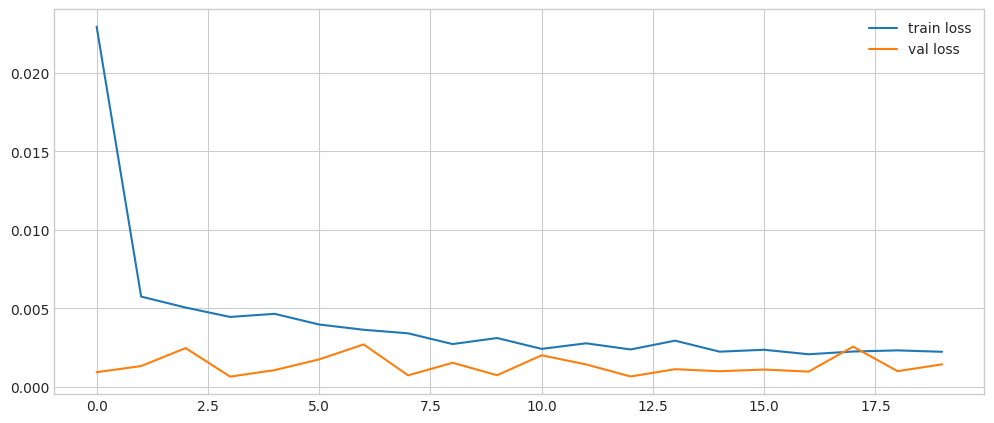

In [35]:
plot_losses(t_losses, v_losses)

테스트 데이터로 평가

In [36]:
def make_predictions(model, dataloader):
    model.eval()
    predictions, actuals = [], []
    for x, y in dataloader:
        with torch.no_grad():
            p = model(x)
            predictions.append(p)
            actuals.append(y.squeeze())
    predictions = torch.cat(predictions).numpy()
    actuals = torch.cat(actuals).numpy()
    return predictions.squeeze(), actuals

In [37]:
eval_loader = DataLoader(
    test_ds, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    drop_last=True
    )

In [38]:
pred, target = make_predictions(model, eval_loader)

In [39]:
result = pd.DataFrame()
result['pred'] = pred
result['target'] = target

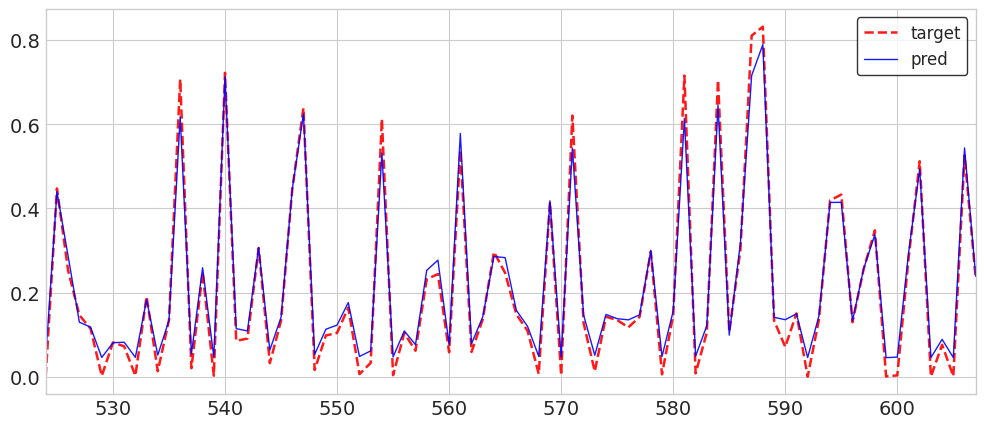

In [40]:
fig, ax = plt.subplots(figsize = (12, 5))
ax.margins(x = 0)

result["target"][524:].plot(
    ax = ax, color = "r", fontsize = 14,
    alpha = 0.9, linewidth = 1.8, style = "--",
    label = "target"
    )

result["pred"][524:].plot(
    ax = ax, color = "b", fontsize = 14,
    alpha = 0.9, linewidth = 1,
    label = "pred"
    )

plt.legend(loc = 'upper right', facecolor = 'white', fontsize = 12, 
           edgecolor = 'black', frameon=True)
#ax.set_ylim([0, 55])
plt.show()